# LAB 3 - LOGISTIC REGRESSION

In this lab we will use the help of statistical packages `statsmodels` and also `sklearn` for plotting and for splitting. These are two of the most complete libraries for statistical modeling in Python.

In [95]:
import numpy as np
import pandas as pd

As usual, we summon `numpy` and `pandas` for dataset representation and manipulation.

In [96]:
loans = pd.read_csv("loans.csv")
loans.info()
loans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 7 columns):
not.fully.paid    9516 non-null int64
installment       9516 non-null float64
log.annual.inc    9516 non-null float64
fico              9516 non-null int64
revol.bal         9516 non-null float64
inq.last.6mths    9516 non-null int64
pub.rec           9516 non-null int64
dtypes: float64(3), int64(4)
memory usage: 520.5 KB


,not.fully.paid,installment,log.annual.inc,fico,revol.bal,inq.last.6mths,pub.rec
0,0,829.10,4.929419,737,28.854,0,0
1,0,228.22,4.812913,707,33.623,0,0
2,0,366.86,4.505150,682,3.511,1,0
3,0,162.34,4.929419,712,33.667,1,0
4,0,102.92,4.907411,667,4.740,0,0


### Renaming Columns

In Python, names with underscores.

In [147]:
new_column_names = {'not.fully.paid':'not_fully_paid', 'log.annual.inc':'log_annual_inc',
                   'revol.bal':'revol_bal', 'inq.last.6mths':'inq_last_6mths', 'pub.rec':'pub_rec'}
loans.rename(columns = new_column_names, inplace = True)

print(loans.columns)

Index(['not_fully_paid', 'installment', 'log_annual_inc', 'fico', 'revol_bal',
       'inq_last_6mths', 'pub_rec'],
      dtype='object')


## Splitting the Data

In previous labs we saw how to split the dataset according to conditions predicated on variable's values. We now wish to split the dataset using randomized methods.

In order to perform the splitting, we import a package from `sklearn`. We also set a fixed random state in order to exactly replicate the results at each execution of the code.

In [173]:
from sklearn.model_selection import train_test_split

y = loans['not_fully_paid']
X = loans.drop(['not_fully_paid'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

`test_size = 0.3` means that we will put 30% of the data in the test set, 70% in the training set

In [174]:
# How many loans have defaulted?

default_false = y_train.where(y_train == 0).count()
default_true = y_train.where(y_train == 1).count()

print(pd.Series({'0': default_false, '1': default_true}))

0    5585
1    1076
dtype: int64


In [175]:
# ?ggscatmat
# ggscatmat(loans.train, alpha = 0.8)

A baseline model can be a so-called "dummy" model, where the classifier predicts every new observation as the majority class. In our case, for a datapoint with any given features, the baseline model will predict 'no-default' always.

In [176]:
# Accuracy of baseline model based on training data would be:
ACC = default_false/(default_false + default_true)

In [177]:
# EXERCISE: Compute accuracy of baseline on testing:



In [178]:
# EXERCISE: What are the TPR and FPR rates of the baseline model?



## Fitting the Logistic Regression Model

Now we can use the statsmodels package to fit the training set to a logistic regression model

In [179]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

?sm.Logit
?smf.logit

In [181]:
# Fit the logistic regression model

loans_train = pd.concat([y_train, X_train], axis=1)
log_model = smf.logit(formula = 'not_fully_paid ~ installment + log_annual_inc + fico + revol_bal + inq_last_6mths + pub_rec',
                   data = loans_train).fit()

# X_train = sm.add_constant(X_train)
# logreg = sm.Logit(y_train, X_train).fit()

print(log_model.summary())

Optimization terminated successfully.
         Current function value: 0.422149
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         not_fully_paid   No. Observations:                 6661
Model:                          Logit   Df Residuals:                     6654
Method:                           MLE   Df Model:                            6
Date:                Sun, 11 Oct 2020   Pseudo R-squ.:                 0.04537
Time:                        23:09:54   Log-Likelihood:                -2811.9
converged:                       True   LL-Null:                       -2945.6
Covariance Type:            nonrobust   LLR p-value:                 8.373e-55
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.5765      0.967      8.866      0.000       6.681      10.472
installment      

In [229]:
# In general, consider this quote:
# "Programs are meant to be read by humans, and only incidentally for computers to execute." - Donald Knuth

In [230]:
# ggscatmat(loans.train, columns = 2:5, alpha = 0.8) # any correlations?

# import seaborn as sns
# corr = loans_train.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

### Predictions

In [231]:
# Example of prediction for a new observation

new_obs = pd.DataFrame(data = {'installment' : [366], 'log_annual_inc' : [4.51], 'fico' : [682],
                               'revol_bal' : [7.53], 'inq_last_6mths' : [1], 'pub_rec' : [0]})
# new_obs = sm.add_constant(new_obs)
log_model.predict(new_obs)

0    0.209408
dtype: float64

In [232]:
# Predictions on the test set 

# X_test = sm.add_constant(X_test)
# y_pred = logreg.predict(X_test)

loans_test = pd.concat([y_test, X_test], axis=1)
y_prob = log_model.predict(loans_test)
y_pred = pd.Series([1 if x > 0.5 else 0 for x in y_prob], index=y_prob.index)

# y_pred is the vector of probabilities as given by your model on the test set. Values between 0 and 1.
# Remember, P(Yi = 1) = 1/(1 + e^(-(b0 + b1*x1 + b2*x2 +...)) )

### Confusion Matrix

In order to evaluate the performance of our classification model, we can make use of confusion matrix to compute a variety of useful metrics

In [241]:
# logreg.pred_table(loans_test)

# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[2404    6]
 [ 435   10]]
[2404    6  435   10]


In [242]:
print(cm.ravel())

[2404    6  435   10]


In [243]:
# What is the accuracy?
(cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())

# What is the True Positive Rate ?


# What is the False Positive rate ?



0.8455341506129597

Be careful about the definitions of FPR, TPR, recall, precision, sensitivity, Specificity etc.
https://en.wikipedia.org/wiki/Sensitivity_and_specificity

In [217]:
# Now, try threshold probability = 0.2.

# What is the accuracy?


# What is the True Positive Rate ?


# What is the False Positive rate ?



## Logistic Regression with Categorical Variables

In [248]:
churn = pd.read_csv("customerchurn.csv")
churn.info()
churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 7 columns):
Churn              7032 non-null int64
MonthlyCharges     7032 non-null float64
SeniorCitizen      7032 non-null int64
PaymentMethod      7032 non-null object
InternetService    7032 non-null object
tenure             7032 non-null int64
Contract           7032 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 384.7+ KB


,Churn,MonthlyCharges,SeniorCitizen,PaymentMethod,InternetService,tenure,Contract
0,0,29.85,0,Electronic check,DSL,1,Month-to-month
1,0,56.95,0,Mailed check,DSL,34,One year
2,1,53.85,0,Mailed check,DSL,2,Month-to-month
3,0,42.30,0,Bank transfer,DSL,45,One year
4,1,70.70,0,Electronic check,Fiber optic,2,Month-to-month


In [249]:
y = churn['Churn']
X = churn.drop(['Churn'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [250]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4922 entries, 5224 to 2008
Data columns (total 6 columns):
MonthlyCharges     4922 non-null float64
SeniorCitizen      4922 non-null int64
PaymentMethod      4922 non-null object
InternetService    4922 non-null object
tenure             4922 non-null int64
Contract           4922 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 269.2+ KB


In [ ]:
# any issues with categorical x variables?

In [261]:
train = pd.concat([y_train, X_train], axis=1)
churn_model = smf.logit(formula = 'Churn ~ MonthlyCharges + SeniorCitizen + PaymentMethod + InternetService + tenure + Contract',
                       data = train).fit()
print(churn_model.summary())

Optimization terminated successfully.
         Current function value: 0.421913
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4911
Method:                           MLE   Df Model:                           10
Date:                Mon, 12 Oct 2020   Pseudo R-squ.:                  0.2695
Time:                        11:24:05   Log-Likelihood:                -2076.7
converged:                       True   LL-Null:                       -2842.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.8982      0.213     -4

In [ ]:
## now take the estimate for SeniorCitizen and transform it into an intuition of how much p will increase



In [267]:
# Let's remove MonthlyCharges
churn_model2 = smf.logit(formula = 'Churn ~ SeniorCitizen + PaymentMethod + InternetService + tenure + Contract',
                       data = train).fit()
print(churn_model2.summary())

Optimization terminated successfully.
         Current function value: 0.422264
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4912
Method:                           MLE   Df Model:                            9
Date:                Mon, 12 Oct 2020   Pseudo R-squ.:                  0.2688
Time:                        11:28:53   Log-Likelihood:                -2078.4
converged:                       True   LL-Null:                       -2842.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.5748      0.122     -4

In [288]:
# Let's remove PaymentMethod Credit Card and PaymentMethodMailed check. How do we do this? Create a new feature. 

# check for mutability problems here:
train2 = train.copy() 
train2['ElectronicCheck'] = (train2['PaymentMethod'] == 'Electronic check').astype('int64')
train2.drop(columns=['PaymentMethod'], inplace=True)
train2.head()

,Churn,MonthlyCharges,SeniorCitizen,InternetService,tenure,Contract,ElectronicCheck
5224,1,101.15,0,Fiber optic,8,Month-to-month,1
3321,1,70.15,1,DSL,38,One year,0
6427,0,79.60,0,DSL,70,Two year,0
4061,0,19.50,0,No,14,One year,0
473,0,53.60,0,DSL,24,Month-to-month,0


In [294]:
churn_model3 = smf.logit(formula = 'Churn ~ SeniorCitizen + ElectronicCheck + InternetService + tenure + Contract',
                       data = train2).fit()
print(churn_model3.summary())

Optimization terminated successfully.
         Current function value: 0.422336
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                          Logit   Df Residuals:                     4914
Method:                           MLE   Df Model:                            7
Date:                Mon, 12 Oct 2020   Pseudo R-squ.:                  0.2687
Time:                        12:16:15   Log-Likelihood:                -2078.7
converged:                       True   LL-Null:                       -2842.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.6254      0.085     -7.363     

In [ ]:
# Let's do the same for test set as well
test = pd.concat([y_test, X_test], axis=1)
test2 = test.copy() 
test2['ElectronicCheck'] = (test2['PaymentMethod'] == 'Electronic check').astype('int64')
test2.drop(columns=['PaymentMethod'], inplace=True)
test2.head()

In [295]:
y_prob = churn_model3.predict(test2)

# predTestLog <- predict(LogModel, newdata=test, type="response") 
# type on default gives log-odds, "response" gives predicted probabilities

In [296]:
# Confusion matricies based on decision tree threshold 
y_pred = pd.Series([1 if x > 1/3 else 0 for x in y_prob], index=y_prob.index)

cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[1213  329]
 [ 154  414]]


## Linear Discriminant Analysis

In [ ]:
# # Using LDA:
# LdaModel <- lda(Churn ~ MonthlyCharges + SeniorCitizen + PaymentMethod + InternetService + tenure + 
#                   Contract, data=train)

# predTestLDA <- predict(LdaModel, newdata=test) #reference https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/predict.lda.html
# predTestLDA_probs <- predTestLDA$posterior[,2]

# table(test$Churn, predTestLDA_probs > 1/3)

## ROC Curves

In [311]:
# Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).

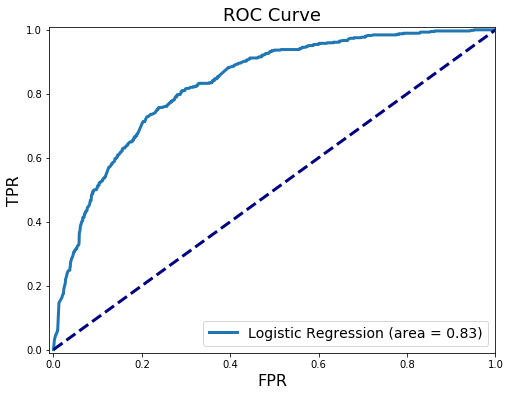

In [317]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

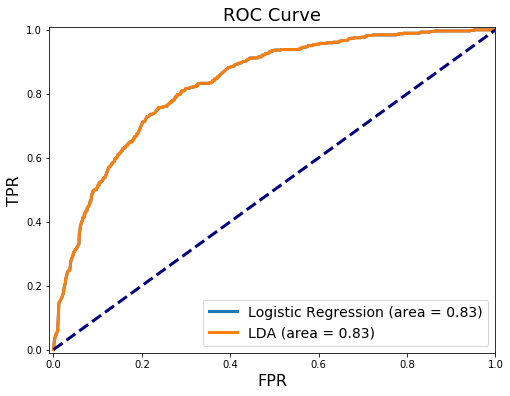

In [329]:
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda)
roc_auc_lda = auc(fpr_lda, tpr_lda)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot(fpr_lda, tpr_lda, lw=3, label='LDA (area = {:0.2f})'.format(roc_auc_lda))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## LDA for Multiclass Problems

LDA advantages for multiclass problems wrt to Logistic Regression

In [319]:

# # For fun, let's use LDA for a multiclass problem
# # Predict payment type based on monthy charges, senior citizen, Internet service, tenure, contract

# lda_fun_mod <- lda(PaymentMethod ~ MonthlyCharges + SeniorCitizen + InternetService + 
#                      tenure + Contract, data = train)

# pred_test_lda_fun <- predict(lda_fun_mod, newdata = test)
# pred_test_lda_fun_class <- pred_test_lda_fun$class
# pred_test_lda_fun_probs <- pred_test_lda_fun$posterior

# tab <- table(test$PaymentMethod, pred_test_lda_fun_class)
# accuracy <- sum(diag(tab))/ sum(tab)

# -----------------------------------------------------------------------------------------